# **Montar el google Drive**

In [1]:
from google.colab import drive
drive.mount("/content/drive/")
%cd drive/My\ Drive/db

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
/content/drive/My Drive/db


# **Subida del conjunto de datos**

**Resize de imagenes a (200x200)**

In [0]:
from PIL import Image

with open("clean.json") as json_file:
  data = json.load(json_file)
  for i in range(len(data)):
    dirName1 = data[i]["image"].split("/")[0]
    dirName = "datasetFace/"+dirName1+"/"+dirName1+"_0001.jpg"
    img = Image.open(dirName)
    img.thumbnail((200,200), Image.ANTIALIAS)
    dirName = "datasetFace/"+dirName1+"/"+dirName1+"_0002.jpg"
    img.save(dirName)

**Cargar la base de datos**

In [2]:
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

datasetX = []
datasetY = []

def rgb2gray(rgb):
  return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

with open("clean.json") as json_file:
  data = json.load(json_file)
  print(type(data))
  for i in range(len(data)):
    dirName = data[i]["image"].split("/")[0]
    dirName = dirName+"/"+dirName+"_0002.jpg"
    desc = (data[i]["descriptions"])
    for edesc in desc:
      datasetX.append(rgb2gray(mpimg.imread("datasetFace/"+dirName,format='jpeg')))
      datasetY.append(edesc["text"].lower())
    print("Load\t",i/4.0,"%")

print(len(datasetX))      #1237
print(datasetX[0].shape)  #(200, 200, 1)

<class 'list'>
Load	 0.0 %
Load	 0.25 %
Load	 0.5 %
Load	 0.75 %
Load	 1.0 %
Load	 1.25 %
Load	 1.5 %
Load	 1.75 %
Load	 2.0 %
Load	 2.25 %
Load	 2.5 %
Load	 2.75 %
Load	 3.0 %
Load	 3.25 %
Load	 3.5 %
Load	 3.75 %
Load	 4.0 %
Load	 4.25 %
Load	 4.5 %
Load	 4.75 %
Load	 5.0 %
Load	 5.25 %
Load	 5.5 %
Load	 5.75 %
Load	 6.0 %
Load	 6.25 %
Load	 6.5 %
Load	 6.75 %
Load	 7.0 %
Load	 7.25 %
Load	 7.5 %
Load	 7.75 %
Load	 8.0 %
Load	 8.25 %
Load	 8.5 %
Load	 8.75 %
Load	 9.0 %
Load	 9.25 %
Load	 9.5 %
Load	 9.75 %
Load	 10.0 %
Load	 10.25 %
Load	 10.5 %
Load	 10.75 %
Load	 11.0 %
Load	 11.25 %
Load	 11.5 %
Load	 11.75 %
Load	 12.0 %
Load	 12.25 %
Load	 12.5 %
Load	 12.75 %
Load	 13.0 %
Load	 13.25 %
Load	 13.5 %
Load	 13.75 %
Load	 14.0 %
Load	 14.25 %
Load	 14.5 %
Load	 14.75 %
Load	 15.0 %
Load	 15.25 %
Load	 15.5 %
Load	 15.75 %
Load	 16.0 %
Load	 16.25 %
Load	 16.5 %
Load	 16.75 %
Load	 17.0 %
Load	 17.25 %
Load	 17.5 %
Load	 17.75 %
Load	 18.0 %
Load	 18.25 %
Load	 18.5 %
Load	 18.75 %

**Guardar en csv**

In [0]:
import csv
with open('trainDataY.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for x in datasetY:
      writer.writerow([x])
      

**Dividir datos de entrenamiento y prueba**

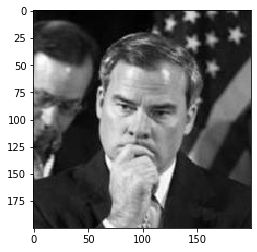

In [4]:
size_train = 1110 # ~90% 127 -> test
trainX, testX = datasetX[:size_train] , datasetX[size_train:]
plt.imshow(trainX[3],cmap = "gray")
plt.savefig("ejemplo.png")

# **Unconditional GAN**

In [0]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout

**Modelo del discriminador**

In [0]:
def define_discriminator(in_shape=(200,200,1)):
	model = Sequential()
	# downsample
	model.add(Conv2D(64, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(64, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

**Modelo del generador**

In [0]:
# define the standalone generator model
def define_generator(latent_dim):
  model = Sequential()
  # foundation for 50x50 image
  n_nodes = 64 * 25 * 25
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((25, 25, 64)))
  # upsample to 50x50
  model.add(Conv2DTranspose(64, (5,5), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 100x100
  model.add(Conv2DTranspose(64, (5,5), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
    # upsample to 200x200
  model.add(Conv2DTranspose(64, (7,7), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # generate
  model.add(Conv2D(1, (7,7), activation='tanh', padding='same'))
  return model

**Modelo GAN**

In [0]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

**Otros**

In [0]:
# load fashion mnist images
def load_real_samples():
  # load dataset
  train_X = np.array(trainX)
  # expand to 3d, e.g. add channels
  X = expand_dims(train_X, axis=-1)
  # convert from ints to floats
  X = X.astype('float32')
  # scale from [0,255] to [-1,1]
  X = (X - 127.5) / 127.5
  return X

In [0]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# select images
	X = dataset[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return X, y

In [0]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [0]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n_samples, 1))
	return X, y

**Train**

In [0]:
# train the generator and discriminator
g1 = [100]*100
d1 = [100]*100
d2 = [100]*100
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=64):
  bat_per_epo = int(dataset.shape[0] / 20)
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
    # enumerate batches over the training set
    for j in range(bat_per_epo):
      # get randomly selected 'real' samples
      X_real, y_real = generate_real_samples(dataset, half_batch)
      # update discriminator model weights
      d_loss1, _ = d_model.train_on_batch(X_real, y_real)
      # generate 'fake' examples
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # update discriminator model weights
      d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
      # prepare points in latent space as input for the generator
      X_gan = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = ones((n_batch, 1))
      # update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      g1[i] = min(g1[i],g_loss)
      d1[i] = min(d1[i],d_loss1)
      d2[i] = min(d2[i],d_loss2)
      # summarize loss on this batch
      print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
  # save the generator model
  g_model.save('generator.h5')

**Ejecutando**

In [16]:
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
train(generator, discriminator, gan_model, dataset, latent_dim)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 1/55, d1=0.710, d2=0.695 g=0.693


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 2/55, d1=0.275, d2=0.698 g=0.692
>1, 3/55, d1=0.112, d2=0.703 g=0.690
>1, 4/55, d1=0.058, d2=0.709 g=0.690
>1, 5/55, d1=0.043, d2=0.715 g=0.697
>1, 6/55, d1=0.020, d2=0.700 g=0.729
>1, 7/55, d1=0.026, d2=0.649 g=0.804
>1, 8/55, d1=0.032, d2=0.588 g=0.876
>1, 9/55, d1=0.020, d2=0.557 g=0.911
>1, 10/55, d1=0.025, d2=0.543 g=0.925
>1, 11/55, d1=0.070, d2=0.535 g=0.933
>1, 12/55, d1=0.025, d2=0.521 g=0.964
>1, 13/55, d1=0.007, d2=0.506 g=1.002
>1, 14/55, d1=0.020, d2=0.512 g=1.028
>1, 15/55, d1=0.012, d2=0.582 g=1.023
>1, 16/55, d1=0.009, d2=0.732 g=1.037
>1, 17/55, d1=0.010, d2=0.653 g=1.467
>1, 18/55, d1=0.103, d2=0.331 g=2.241
>1, 19/55, d1=0.289, d2=0.305 g=1.978
>1, 20/55, d1=0.108, d2=0.332 g=2.497
>1, 21/55, d1=0.321, d2=0.306 g=2.094
>1, 22/55, d1=0.145, d2=0.334 g=2.258
>1, 23/55, d1=0.223, d2=0.374 g=2.063
>1, 24/55, d1=0.173, d2=0.417 g=1.944
>1, 25/55, d1=0.140, d2=0.532 g=1.711
>1, 26/55, d1=0.133, d2=0.853 g=1.537
>1, 27/55, d1=0.041, d2=1.437 g=1.374
>1, 28/55, d1=0.067,

**Ejemplos de generacion**

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


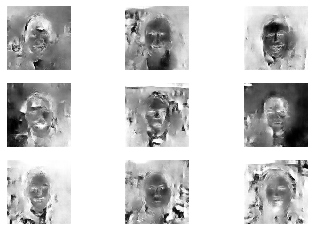

In [19]:
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# create and save a plot of generated images (reversed grayscale)
def show_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.savefig("resultado4.png")
	pyplot.show()
 
# load model
model = load_model('generator.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# plot the result
show_plot(X, 3)

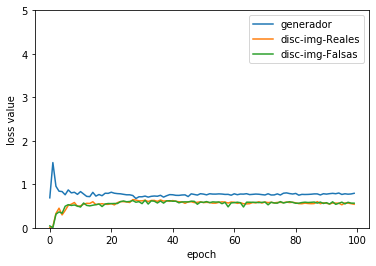

In [20]:
import matplotlib.pyplot as plt
c = range(0,100)

plt.ylim(0, 5.0)
plt.plot(c,g1, label="generador")
plt.plot(c,d1, label="disc-img-Reales")
plt.plot(c,d2, label="disc-img-Falsas")
plt.ylabel('loss value')
plt.xlabel('epoch')
plt.legend()


plt.savefig('result1GAN1.png')

# **Conditional GAN**

**Word2vec**

In [0]:
import pandas as pd
from gensim.models import Word2Vec
import logging
import re

# Diplay log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Load data
data = pd.read_csv('trainDataY.csv', header=None)

# Preprocess text
def tokenize(sentence):
    remove_dots = re.sub("[.]", "", sentence.lower())
    return re.findall("[A-Za-z]{2,}", remove_dots)

sentences = []
for sentence in data[0].values:
    sentences.append(tokenize(sentence))

# Train and save word2vec model
model = Word2Vec(sentences, min_count=5, size=100, iter=400, seed=96)
model.save('word2vec.bin')

# Load and test word2vec model
loaded_w2v = Word2Vec.load('word2vec.bin')
print(loaded_w2v.wv.most_similar(positive=['girl']))
print(loaded_w2v.wv['girl'])


2019-12-20 03:53:48,376 : INFO : collecting all words and their counts
2019-12-20 03:53:48,377 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-12-20 03:53:48,386 : INFO : collected 2740 word types from a corpus of 26772 raw words and 1237 sentences
2019-12-20 03:53:48,386 : INFO : Loading a fresh vocabulary
2019-12-20 03:53:48,392 : INFO : effective_min_count=5 retains 564 unique words (20% of original 2740, drops 2176)
2019-12-20 03:53:48,394 : INFO : effective_min_count=5 leaves 23460 word corpus (87% of original 26772, drops 3312)
2019-12-20 03:53:48,398 : INFO : deleting the raw counts dictionary of 2740 items
2019-12-20 03:53:48,400 : INFO : sample=0.001 downsamples 80 most-common words
2019-12-20 03:53:48,401 : INFO : downsampling leaves estimated 14423 word corpus (61.5% of prior 23460)
2019-12-20 03:53:48,405 : INFO : estimated required memory for 564 words and 100 dimensions: 733200 bytes
2019-12-20 03:53:48,406 : INFO : resetting layer weights


[('woman', 0.41124922037124634), ('boy', 0.390610009431839), ('female', 0.3749181628227234), ('lady', 0.2767566442489624), ('either', 0.27229854464530945), ('years', 0.27150022983551025), ('herself', 0.2415943294763565), ('messy', 0.23958952724933624), ('women', 0.2395847886800766), ('frown', 0.22598347067832947)]
[ 2.182694   -3.726872    4.3032417  -3.280096    0.44057068 -0.9229723
  0.36610797  0.80471885 -0.573693   -1.9369487   3.2093508  -2.0639446
  0.2464344  -4.4605484  -2.4450967  -0.6231723  -0.3673197   2.393617
 -2.5053635   0.0341744  -1.6436132   0.23731689 -0.08190335  0.87344205
 -2.9985125  -1.3726795  -1.8138666   0.42248726  1.6725907   1.7352874
 -0.37063816  0.09246446  1.3256909  -2.8244169   2.9198895   0.20510165
  1.3781668   0.23625815 -3.035927    0.84979475  1.2488223  -4.8982954
 -2.8213491  -0.9640026   4.912128   -1.2428341   0.7773983  -0.8576776
 -0.5347328   3.331375   -1.6959839   0.14117509 -0.42503938 -1.3111861
 -4.7812014  -3.2291894   0.4404466

**Convertir texto a Matriz**

In [0]:
dataY = []
m=0
pos = 0
word_vectors = loaded_w2v.wv
for i in range(len(datasetY)):
  aux = [[1]*100]*100
  w = ""
  m = max(m,pos)
  pos = 0
  for j in range(len(datasetY[i])):
    if datasetY[i][j].isalpha():
      w+=datasetY[i][j]
    else:
      if w in word_vectors.vocab:
        aux[pos] = loaded_w2v.wv[w]
        pos+=1
      w=""
  if w in word_vectors.vocab:
    aux[pos]=loaded_w2v.wv[w]
    pos+=1
  dataY.append(aux)

trainY, testY = dataY[:size_train] , dataY[size_train:]
print(len(trainY[0][0]))
trainYY = np.zeros((1110, 100, 100))
for i in range(len(trainY)):
  for j in range(len(trainY[i])):
    for k in range(len(trainY[i][j])):
      trainYY[i][j][k]=trainY[i][j][k]
print(trainYY.shape)
trainY = trainYY
print(trainY.shape)

100
(1110, 100, 100)
(1110, 100, 100)


In [0]:
# example of training an conditional gan on the fashion mnist dataset
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate

**Modelo de discriminador**

In [0]:
# define the standalone discriminator model
def define_discriminator(in_shape=(200,200,1)):
  in_label = Input(shape=(None,100))
  n_nodes = in_shape[0] * 2 #######################
  li = Dense(n_nodes)(in_label)
  # reshape to additional channel
  li = Reshape((in_shape[0], in_shape[1], 1))(li)
  # image input
  in_image = Input(shape=in_shape)
  # concat label as a channel
  merge = Concatenate()([in_image, li])
  # downsample
  fe = Conv2D(64, (7,7), strides=(2,2), padding='same')(merge)
  fe = LeakyReLU(alpha=0.2)(fe)
  # downsample
  fe = Conv2D(64, (5,5), strides=(2,2), padding='same')(fe)
  fe = LeakyReLU(alpha=0.2)(fe)
  # flatten feature maps
  fe = Flatten()(fe)
  # dropout
  fe = Dropout(0.4)(fe)
  # output
  out_layer = Dense(1, activation='sigmoid')(fe)
  # define model
  model = Model([in_image, in_label], out_layer)
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

**Modelo generador**

In [0]:
# define the standalone generator model
def define_generator(latent_dim):
  in_label = Input(shape=(None,100))
  n_nodes = 2 * 2
  li = Dense(n_nodes)(in_label)
  # reshape to additional channel
  li = Reshape((25, 25, 1))(li)
  # image generator input
  in_lat = Input(shape=(latent_dim,))
  # foundation for 25x25 image
  n_nodes = 64 * 25 * 25
  gen = Dense(n_nodes)(in_lat)
  gen = LeakyReLU(alpha=0.2)(gen)
  gen = Reshape((25, 25, 64))(gen)
  # merge image gen and label input
  merge = Concatenate()([gen, li])
  # upsample to 50x50
  gen = Conv2DTranspose(64, (4,4), strides=(2,2), padding='same')(merge)
  gen = LeakyReLU(alpha=0.2)(gen)
  # upsample to 100x100
  gen = Conv2DTranspose(64, (4,4), strides=(2,2), padding='same')(gen)
  gen = LeakyReLU(alpha=0.2)(gen)
  # upsample to 200x200
  gen = Conv2DTranspose(64, (4,4), strides=(2,2), padding='same')(gen)
  gen = LeakyReLU(alpha=0.2)(gen)
  # output
  out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
  # define model
  model = Model([in_lat, in_label], out_layer)
  return model

**Modelo GAN**

In [0]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input
	# get image output from the generator model
	gen_output = g_model.output
	# connect image output and label input from generator as inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

**Otros**

In [0]:
def load_real_samples():
  # load dataset
  (train_X, trainy) = trainX , trainY
  # expand to 3d, e.g. add channels
  X = expand_dims(train_X, axis=-1)
  # convert from ints to floats
  X = X.astype('float32')
  # scale from [0,255] to [-1,1]
  X = (X - 127.5) / 127.5
  return [X, trainy]
 
# select real samples
def generate_real_samples(dataset, n_samples):
  # split into images and labels
  images, labels = dataset
  # choose random instances
  ix = randint(0, images.shape[0], n_samples)
  # select images and labels
  X, labels = images[ix], labels[ix]
  # generate class labels
  y = ones((n_samples, 1))
  return [X, labels], y

In [0]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, len(trainY), n_samples)
	return [z_input, trainY[labels]]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
  print(latent_dim)
  # generate points in latent space
  z_input, labels_input = generate_latent_points(latent_dim, n_samples)
  # predict outputs
  print(labels_input.shape)
  print(z_input.shape)
  images = generator.predict([z_input, labels_input])
  # create class labels
  y = zeros((n_samples, 1))
  return [images, labels_input], y

**Training**

In [0]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=64):
  bat_per_epo = int(dataset[0].shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(1):
    # enumerate batches over the training set
    for j in range(1):
      # get randomly selected 'real' samples
      #[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
      # update discriminator model weights
      #d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
      # generate 'fake' examples
      #[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # update discriminator model weights
      #d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
      # prepare points in latent space as input for the generator
      [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = ones((n_batch, 1))
      # update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
      # summarize loss on this batch
      #print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
       # (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
  # save the generator model
  g_model.save('cgan_generator.h5')

In [0]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
d_model.summary()
# create the generator
g_model = define_generator(latent_dim)
g_model.summary()
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
#train(g_model, d_model, gan_model, dataset, latent_dim)

Model: "model_102"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_141 (InputLayer)          (None, None, 100)    0                                            
__________________________________________________________________________________________________
dense_141 (Dense)               (None, None, 400)    40400       input_141[0][0]                  
__________________________________________________________________________________________________
input_142 (InputLayer)          (None, 200, 200, 1)  0                                            
__________________________________________________________________________________________________
reshape_106 (Reshape)           (None, 200, 200, 1)  0           dense_141[0][0]                  
__________________________________________________________________________________________

InvalidArgumentError: ignored